## DeepLIFT

Based on the papers: <i>Learning Important Features Through Propagating Activation Differences</i> and <i>Towards Better Understanding of Gradient-based Attribution Methods for Deep Neural Networks</i>. Rescale rule.

Relevance score for node i in layer l:
    
$$ r_{i}^{\ell} = \sum_{j} \frac{z_{ji}-\bar{z}_{ji}}{\sum{z_{ji}}-\sum{\bar{z}_{ji}}} r_{j}^{\ell+1} $$

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,Reshape,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_train = x_train[y_train <= 3] # using numbers 0,..,3
y_train = y_train[y_train <= 3]
x_train = np.expand_dims(x_train,axis=-1)
x_train,y_train = x_train[:24600],y_train[:24600]
x_train = np.reshape(x_train,(24600,-1))
x_train.shape,y_train.shape

((24600, 784), (24600,))

In [3]:
x_train = x_train/255 # scaling the images

In [4]:
def get_model():
    """ Simple feed-forward model
    """
    x = Input(shape=(784))
    h1 = Dense(100,activation='relu')(x)
    h2 = Dense(50,activation='relu')(h1)
    o = Dense(4,activation='softmax')(h2)
    
    model = Model(inputs=x,outputs=[h1,h2,o])
    return model

In [5]:
@tf.function
def train(model,optimizer,x_train_subset,y_train_subset):
    with tf.GradientTape() as tape:
        _,_,o = model(x_train_subset)
        loss = SparseCategoricalCrossentropy()(y_train_subset,o)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [6]:
model = get_model()

In [7]:
batch_size=50
epochs=5
optimizer = Adam(lr=0.01)

for epoch_i in range(epochs):
    losses = []
    for i in range(0,len(x_train),batch_size):
        x_train_subset = x_train[i:i+batch_size]
        y_train_subset = y_train[i:i+batch_size]
        batch_loss = train(model,optimizer,x_train_subset,y_train_subset)
        losses.append(float(batch_loss))
        
    print("Epoch {}: {}".format(epoch_i+1,round(sum(losses)/len(losses),6)))

Epoch 1: 0.106497
Epoch 2: 0.052624
Epoch 3: 0.038237
Epoch 4: 0.028195
Epoch 5: 0.034505


In [8]:
weights = {} # store all weights as numpy arrays
for i in range(0,len(model.trainable_variables)//2):
    weights["w"+str(i+1)] = model.trainable_variables[i*2].numpy()
    weights["b"+str(i+1)] = model.trainable_variables[i*2+1].numpy()

In [9]:
def generate_lift_heatmap(example,weights):
    """
    """
    example_to_print = example.reshape(28,28)
    example = np.expand_dims(example,axis=0)
    ref_example = np.zeros((1,784)).astype("float32") # reference example all zeros

    a1,a2,a3 = model(example)
    a1,a2,a3 = a1.numpy(),a2.numpy(),a3.numpy()
    inputs = {'a0':example,'a1':a1,'a2':a2}

    a1_r,a2_r,a3_r = model(ref_example)
    a1_r,a2_r,a3_r = a1_r.numpy(),a2_r.numpy(),a3_r.numpy()
    ref_inputs = {'a0':ref_example,'a1':a1_r,'a2':a2_r}

    prev_r = [list(a3[0])] # the relevance of the previous layer

    for i in [3,2,1]:
        # getting relevance scores for all nodes in layer l, based on layer l+1:
        r_scores = [0 for _ in range(inputs['a'+str(i-1)].shape[-1])] # init scores for this layer
        prev_r_scores = prev_r[-1]

        for r_i in range(len(prev_r_scores)):

            z_i = np.squeeze((inputs['a'+str(i-1)]*weights['w'+str(i)][:,r_i]) + weights['b'+str(i)][r_i])
            z_i_ref = np.squeeze((ref_inputs['a'+str(i-1)]*weights['w'+str(i)][:,r_i]) + weights['b'+str(i)][r_i])

            z_sum = np.sum(z_i)
            z_sum_ref = np.sum(z_i_ref)
            z_denom = z_sum-z_sum_ref

            for j in range(len(z_i)):
                z_score = ((z_i[j]-z_i_ref[j])/z_denom)*prev_r_scores[r_i]
                r_scores[j]+=z_score

            prev_r.append(r_scores)

    heatmap = np.abs(np.reshape(np.array(r_scores),(28,28)))
    return example_to_print,heatmap

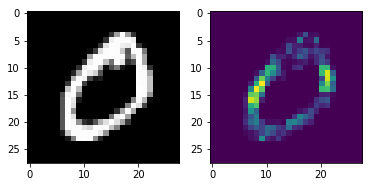

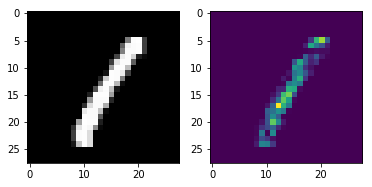

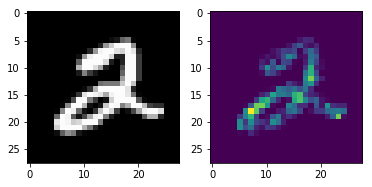

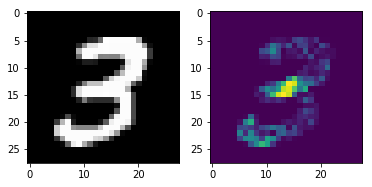

In [10]:
for i in [0,1,2,4]:
    example_to_print,heatmap = generate_lift_heatmap(x_train[i],weights)
    plt.subplot(1,2,1)
    plt.imshow(example_to_print,cmap="gray")
    plt.subplot(1,2,2)
    plt.imshow(heatmap)
    plt.show()